In [43]:
# imports
import pandas as pd
import numpy as np
import pyeuropeana.apis as apis
import pyeuropeana.utils as utils
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import urllib.request
from urllib.parse import quote
from PIL import Image
from io import BytesIO

In [112]:
europeana_api_key = os.environ['EUROPEANA_API_KEY']
rows_per_query = 1000
num_queries = 100
get_data = False  # SET TO TRUE TO GET DATA FROM EUROPEANA
get_imgs = False  # SET TO TRUE TO GET IMAGES FROM EUROPEANA

## Getting Data from Europeana

In [113]:
def fetch_data(api_key, cursor, rows):
    results = apis.search(
        api_key=api_key,
        query='*',
        qf='LANGUAGE:en AND TYPE:IMAGE',
        reusability='open',
        theme='art',
        cursor=cursor,
        rows=rows,
        profile='rich',
    )
    return results

In [114]:
if get_data:
    all_records = []
    cursor = '*'
    pbar = tqdm(range(num_queries))

    for i in pbar:
        pbar.set_description(f'Fetching records with cursor: {cursor}')
        results = fetch_data(europeana_api_key, cursor, rows_per_query)
        
        if 'items' in results:
            records = utils.search2df(results)
            all_records.append(records)
        else:
            print("No more records found.")
            break

        # Update the cursor for the next query
        cursor = results.get('nextCursor')
        if cursor is None:
            print("No nextCursor found.")
            break

        if i % 10 == 0:
            # Save the current state of the data
            combined_df = pd.concat(all_records, ignore_index=True)
            combined_df.to_csv('data/europeana.csv', index=False)

In [115]:
combined_df = pd.concat(all_records, ignore_index=True)
combined_df.to_csv('data/europeana.csv', index=False)

## Getting Images

In [116]:
df = pd.read_csv('data/europeana.csv')
# remove samples without description
df = df[df['description'].notna()]
print(f'Number of samples: {len(df)}')

Number of samples: 19893


In [117]:
if get_imgs:  # TODO: don't get images that already exist
    imgs_that_are_there = [file for file in os.listdir('data/images') if file.endswith('.jpg')]
    for i in tqdm(range(len(df))):
        if f'{df.iloc[i]["europeana_id"].replace("/", "_")}.jpg' in imgs_that_are_there:
            continue
        sample = df.iloc[i]
        image_url, art_id = sample['image_url'], sample['europeana_id'].replace('/', '_')
        # get image and save into data
        try:
            response = urllib.request.urlopen(image_url)
        except urllib.error.HTTPError as e:
            print(f'HTTPError: {e.code} for {image_url}')
            continue
        except urllib.error.URLError as e:
            print(f'URLError: {e.reason} for {image_url}')
            continue
        img = Image.open(BytesIO(response.read()))
        img.save(f'data/images/{art_id}.jpg')

    

In [98]:
def plot_sample(df, nrows=3, ncols=4):
    # plot on black background
    plt.style.use('dark_background')
    idxs = np.random.choice(df.index, nrows * ncols, replace=False)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3), dpi=100)
    for idx, ax in tqdm(zip(idxs, axes.flatten())):
        row = df.loc[idx]
        img_url = row['image_url']
        with urllib.request.urlopen(img_url) as url:
            f = url.read()
        img = Image.open(BytesIO(f))
        ax.imshow(img)
        ax.set_title(row['title'][:20])
        ax.axis('off')
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()
    

15it [00:05,  2.80it/s]


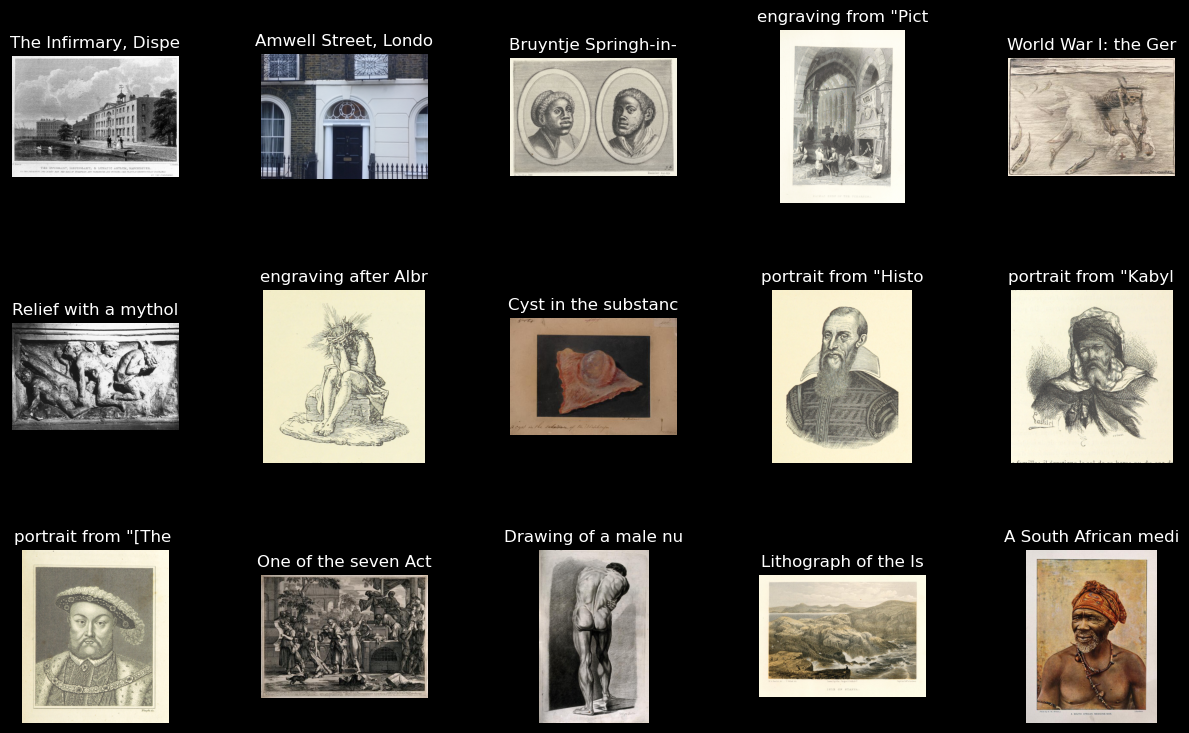

In [118]:
plot_sample(df, ncols=5)

## Building a Dataset